# SABR Model Test Code

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import imp
import numpy as np
import matplotlib.pyplot as plt
#import sys
#sys.path.insert(sys.path.index('')+1, 'D:/Github/PyFENG')
import pyfeng as pf
import option_models as opt

np.set_printoptions(precision=3)

## 1. Pricing using Hagan's formula (provided)

### (1) SABR for $0<\beta\le 1$

In [3]:
# Parameters
strike = np.linspace(75,125,num=25)
forward = 100
sigma = 0.2
texp = 1
vov = 0.5
rho = 0.25
beta = 1

In [4]:
# Create model
sabr_bsm = pf.SabrHagan2002(sigma, vov=vov, rho=rho, beta=beta)
#sabr_bsm.__dict__

In [5]:
# This is how you price. you can get either price or bsm_vol
price = sabr_bsm.price(strike, forward, texp)
bsm_vol = sabr_bsm.vol_smile(strike, forward, texp)

price, bsm_vol

(array([25.631, 23.751, 21.924, 20.159, 18.465, 16.85 , 15.32 , 13.884,
        12.543, 11.302, 10.159,  9.115,  8.165,  7.306,  6.532,  5.838,
         5.217,  4.663,  4.17 ,  3.731,  3.342,  2.996,  2.689,  2.417,
         2.175]),
 array([0.204, 0.203, 0.202, 0.201, 0.2  , 0.2  , 0.2  , 0.2  , 0.201,
        0.202, 0.203, 0.204, 0.205, 0.206, 0.208, 0.21 , 0.211, 0.213,
        0.215, 0.217, 0.219, 0.221, 0.223, 0.225, 0.227]))

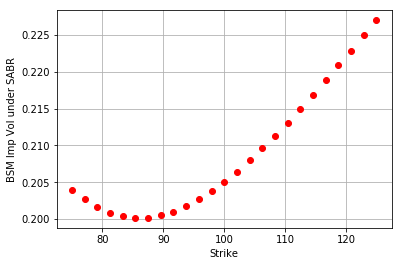

In [6]:
# volatility smile plot: try with different parameters
plt.plot(strike, bsm_vol, 'ro')
#plt.axis([0, 6, 0, 20])
plt.ylabel('BSM Imp Vol under SABR')
plt.xlabel('Strike')
plt.grid()
plt.show()

### (2) SABR for $\beta=0$

In [7]:
strike = np.linspace(75,125,num=25)
#strike = 1
forward = 100
sigma = 20
texp = 1
alpha = 0.5
rho = -0.25

In [8]:
sabr_norm = pf.SabrHagan2002(sigma, vov=vov, rho=rho, beta=0)
price = sabr_norm.price(strike, forward, texp)
nvol = sabr_norm.vol_smile(strike, forward, texp, model='norm')

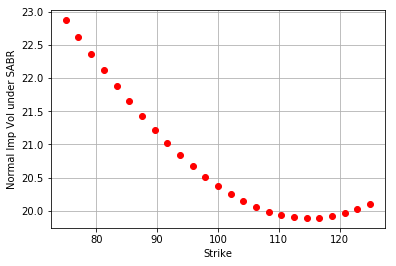

In [9]:
plt.plot(strike, nvol, 'ro')
#plt.axis([0, 6, 0, 20])
plt.ylabel('Normal Imp Vol under SABR')
plt.xlabel('Strike')
plt.grid()
plt.show()

### (3) Smile calibration to 3 options

In [10]:
strike3 = np.array([90, 100, 110])
price3 = sabr_bsm.price(strike3, forward, texp)
vol3 = sabr_bsm.vol_smile(strike3, forward, texp)

price3, vol3

(array([13.608,  8.165,  4.769]), array([0.201, 0.205, 0.213]))

In [11]:
sabr_bsm.__dict__

{'sigma': 0.2,
 'intr': 0.0,
 'divr': 0.0,
 'is_fwd': False,
 'vov': 0.5,
 'rho': 0.25,
 'beta': 1}

In [12]:
# makre sure this return the original sigma, alpha, rho
sabr_bsm.calibrate3(vol3, strike3, forward, texp, is_vol=True)

{'sigma': 0.2000000000001008,
 'vov': 0.4999999998672808,
 'rho': 0.24999999998258432}

In [13]:
# makre sure this return the original sigma, alpha, rho
sabr_bsm.calibrate3(price3, strike3, forward, texp, is_vol=False)

{'sigma': 0.19999999979636335,
 'vov': 0.5000000129299839,
 'rho': 0.2499999894054446}

## 2. Pricing under MC method

In [14]:
strike = np.linspace(75,125,num=25)
forward = 100

In [15]:
# instantiate mc model from the hagan model's parameters
print(sabr_bsm.__dict__)
sabr_bsm_mc = opt.sabr.ModelBsmMC(sabr_bsm.sigma, vov=sabr_bsm.vov, rho=sabr_bsm.rho, beta=1)

{'sigma': 0.2, 'intr': 0.0, 'divr': 0.0, 'is_fwd': False, 'vov': 0.5, 'rho': 0.25, 'beta': 1}


In [16]:
sabr_bsm_mc.price(strike, forward, texp)

array([23.267, 21.428, 19.639, 17.911, 16.245, 14.649, 13.149, 11.746,
       10.446,  9.243,  8.128,  7.119,  6.196,  5.347,  4.571,  3.866,
        3.228,  2.661,  2.162,  1.728,  1.359,  1.049,  0.802,  0.606,
        0.454])

In [17]:
price_hagan = sabr_bsm.price(strike, forward, texp)
price_mc = sabr_bsm_mc.price(strike, forward, texp)

# make sure the two prices are similar
price_hagan, price_mc

(array([25.631, 23.751, 21.924, 20.159, 18.465, 16.85 , 15.32 , 13.884,
        12.543, 11.302, 10.159,  9.115,  8.165,  7.306,  6.532,  5.838,
         5.217,  4.663,  4.17 ,  3.731,  3.342,  2.996,  2.689,  2.417,
         2.175]),
 array([23.267, 21.428, 19.639, 17.911, 16.245, 14.649, 13.149, 11.746,
        10.446,  9.243,  8.128,  7.119,  6.196,  5.347,  4.571,  3.866,
         3.228,  2.661,  2.162,  1.728,  1.359,  1.049,  0.802,  0.606,
         0.454]))

### Repeat the same for beta = 0

In [18]:
# instantiate mc model from the hagan model's parameters
print(sabr_norm.__dict__)
sabr_norm_mc = opt.sabr.ModelNormalMC(sabr_norm.sigma, vov=sabr_norm.vov, rho=sabr_norm.rho, beta=0)

{'sigma': 20, 'intr': 0.0, 'divr': 0.0, 'is_fwd': False, 'vov': 0.5, 'rho': -0.25, 'beta': 0}


In [19]:
price_hagan = sabr_norm.price(strike, forward, texp)
price_mc = sabr_norm_mc.price(strike, forward, texp)

# make sure the two prices are similar
price_hagan, price_mc

(array([26.591, 24.753, 22.952, 21.192, 19.479, 17.818, 16.215, 14.675,
        13.206, 11.811, 10.497,  9.268,  8.129,  7.08 ,  6.125,  5.262,
         4.49 ,  3.807,  3.207,  2.686,  2.237,  1.854,  1.53 ,  1.257,
         1.03 ]),
 array([24.983, 23.338, 21.733, 20.171, 18.657, 17.199, 15.802, 14.47 ,
        13.202, 12.005, 10.871,  9.797,  8.767,  7.784,  6.859,  5.988,
         5.17 ,  4.419,  3.748,  3.153,  2.628,  2.177,  1.792,  1.462,
         1.184]))

## 3. Pricing under conditional MC method

In [20]:
strike = np.linspace(75,125,num=25)
forward = 100

In [21]:
# instantiate mc model from the hagan model's parameters
print(sabr_bsm.__dict__)
sabr_bsm_cmc = opt.sabr.ModelBsmCondMC(sabr_bsm.sigma, vov=sabr_bsm.vov, rho=sabr_bsm.rho, beta=1)

{'sigma': 0.2, 'intr': 0.0, 'divr': 0.0, 'is_fwd': False, 'vov': 0.5, 'rho': 0.25, 'beta': 1}


In [22]:
sabr_bsm_cmc.price(strike, forward, texp)

array([25.693, 23.812, 21.983, 20.216, 18.52 , 16.903, 15.371, 13.932,
       12.59 , 11.346, 10.201,  9.155,  8.203,  7.342,  6.567,  5.871,
        5.248,  4.693,  4.198,  3.759,  3.368,  3.021,  2.713,  2.44 ,
        2.197])

In [23]:
price_hagan = sabr_bsm.price(strike, forward, texp)
price_mc = sabr_bsm_cmc.price(strike, forward, texp)

# make sure the two prices are similar
price_hagan, price_mc

(array([25.631, 23.751, 21.924, 20.159, 18.465, 16.85 , 15.32 , 13.884,
        12.543, 11.302, 10.159,  9.115,  8.165,  7.306,  6.532,  5.838,
         5.217,  4.663,  4.17 ,  3.731,  3.342,  2.996,  2.689,  2.417,
         2.175]),
 array([25.693, 23.812, 21.983, 20.216, 18.52 , 16.903, 15.371, 13.932,
        12.59 , 11.346, 10.201,  9.155,  8.203,  7.342,  6.567,  5.871,
         5.248,  4.693,  4.198,  3.759,  3.368,  3.021,  2.713,  2.44 ,
         2.197]))

### Repeat the same for beta = 0

In [24]:
strike = np.linspace(75,125,num=25)
forward = 100

In [25]:
# instantiate mc model from the hagan model's parameters
print(sabr_norm.__dict__)
sabr_norm_cmc = opt.sabr.ModelNormalCondMC(sabr_norm.sigma, vov=sabr_norm.vov, rho=sabr_norm.rho, beta=0)

{'sigma': 20, 'intr': 0.0, 'divr': 0.0, 'is_fwd': False, 'vov': 0.5, 'rho': -0.25, 'beta': 0}


In [26]:
sabr_norm_cmc.price(strike, forward, texp)

array([26.551, 24.713, 22.912, 21.152, 19.439, 17.779, 16.176, 14.637,
       13.168, 11.774, 10.461,  9.234,  8.095,  7.048,  6.094,  5.233,
        4.463,  3.782,  3.184,  2.665,  2.219,  1.837,  1.515,  1.244,
        1.018])

In [27]:
price_hagan = sabr_norm.price(strike, forward, texp)
price_mc = sabr_norm_cmc.price(strike, forward, texp)
    
# make sure the two prices are similar
price_hagan, price_mc

(array([26.591, 24.753, 22.952, 21.192, 19.479, 17.818, 16.215, 14.675,
        13.206, 11.811, 10.497,  9.268,  8.129,  7.08 ,  6.125,  5.262,
         4.49 ,  3.807,  3.207,  2.686,  2.237,  1.854,  1.53 ,  1.257,
         1.03 ]),
 array([26.551, 24.713, 22.912, 21.152, 19.439, 17.779, 16.176, 14.637,
        13.168, 11.774, 10.461,  9.234,  8.095,  7.048,  6.094,  5.233,
         4.463,  3.782,  3.184,  2.665,  2.219,  1.837,  1.515,  1.244,
         1.018]))

## Compare the MC variance between brute-force MC and conditional MC
For this, you should not use the random number seed

In [38]:
mc_bsm_random=[np.zeros(25)]
for i in range(0,101):
    mc_bsm_random = np.append(mc_bsm_random,[sabr_bsm_mc.price(strike, forward, texp, random_seed=None)],axis=0)

In [39]:
mc_norm_random=[np.zeros(25)]
for i in range(0,101):
    mc_norm_random=np.append(mc_norm_random,[sabr_norm_mc.price(strike, forward, texp, random_seed=None)],axis=0)

In [40]:
cmc_bsm_random=[np.zeros(25)]
for i in range(0,101):
    cmc_bsm_random=np.append(cmc_bsm_random,[sabr_bsm_cmc.price(strike, forward, texp, random_seed=None)],axis=0)

In [41]:
cmc_norm_random=[np.zeros(25)]
for i in range(0,101):
    cmc_norm_random=np.append(cmc_norm_random,[sabr_norm_cmc.price(strike, forward, texp, random_seed=None)],axis=0)

In [52]:
np.var(mc_bsm_random[1:],axis=0), np.var(mc_norm_random[1:],axis=0), np.var(cmc_bsm_random[1:],axis=0), np.var(cmc_norm_random[1:],axis=0)

(array([2.451, 2.39 , 2.317, 2.231, 2.134, 2.026, 1.907, 1.779, 1.646,
        1.512, 1.378, 1.247, 1.115, 0.985, 0.86 , 0.744, 0.64 , 0.549,
        0.467, 0.396, 0.334, 0.282, 0.237, 0.2  , 0.169]),
 array([3.342, 3.221, 3.095, 2.967, 2.839, 2.708, 2.573, 2.431, 2.283,
        2.129, 1.973, 1.814, 1.651, 1.487, 1.326, 1.176, 1.037, 0.91 ,
        0.794, 0.687, 0.59 , 0.502, 0.424, 0.355, 0.295]),
 array([0.009, 0.009, 0.009, 0.009, 0.009, 0.009, 0.009, 0.009, 0.009,
        0.009, 0.009, 0.009, 0.009, 0.009, 0.009, 0.009, 0.009, 0.009,
        0.009, 0.009, 0.008, 0.008, 0.008, 0.007, 0.007]),
 array([0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.   , 0.   , 0.   ,
        0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
        0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ]))